# NN Implementation using Pytorch

RGB Image

In [ ]:
# Import dependencies
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Get the Data

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transforms, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms, download=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=34, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# class names
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
image, label = train_data[0]

In [ ]:
image.shape

torch.Size([3, 32, 32])

## Model

In [ ]:
class CNeuralNet(nn.Module):

  def __init__(self):
    super().__init__()

    # Convolutional Neural Networks Architecture
    self.conv1 = nn.Conv2d(3, 12, 5)   # 12, 28, 28
    self.bn1 = nn.BatchNorm2d(12)   # Batch Normalization for the 1st conv layer

    self.pool = nn.MaxPool2d(2, 2)  # 12, 14, 14
    self.conv2 = nn.Conv2d(12, 24, 5)
    self.bn2 = nn.BatchNorm2d(24)

    self.fc1 = nn.Linear(24*5*5, 120)
    self.bn3 = nn.BatchNorm1d(120)
    self.fc2 = nn.Linear(120, 84)
    self.bn4 = nn.BatchNorm1d(84)
    self.fc3 = nn.Linear(84, 10)   # CIFAR10 has 10 categories

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1)      # for the fully connected layer
    x = F.relu(self.bn3(self.fc1(x)))
    x = F.relu(self.bn4(self.fc2(x)))
    x = self.fc3(x)      # No activation for final layer (softmax will likely follow in the loss fucntion)

    return x



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
## Visualize the CNN Architecture
from torchsummary import summary

model = CNeuralNet().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 28, 28]             912
       BatchNorm2d-2           [-1, 12, 28, 28]              24
         MaxPool2d-3           [-1, 12, 14, 14]               0
            Conv2d-4           [-1, 24, 10, 10]           7,224
       BatchNorm2d-5           [-1, 24, 10, 10]              48
         MaxPool2d-6             [-1, 24, 5, 5]               0
            Linear-7                  [-1, 120]          72,120
       BatchNorm1d-8                  [-1, 120]             240
            Linear-9                   [-1, 84]          10,164
      BatchNorm1d-10                   [-1, 84]             168
           Linear-11                   [-1, 10]             850
Total params: 91,750
Trainable params: 91,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## Train

In [ ]:
model = CNeuralNet()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):
  print(f"Epoch: {epoch}")

  running_loss = 0

  for i, data in enumerate(train_loader):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  print(f"Loss {running_loss / len(train_loader):.4f}")

Epoch: 0
Loss 1.5299
Epoch: 1
Loss 1.1950
Epoch: 2
Loss 1.0522
Epoch: 3
Loss 0.9620
Epoch: 4
Loss 0.8867
Epoch: 5
Loss 0.8355
Epoch: 6
Loss 0.7897
Epoch: 7
Loss 0.7510
Epoch: 8
Loss 0.7132
Epoch: 9
Loss 0.6833


## Saving the NN model from pytorch

In [ ]:
torch.save(model.state_dict(), 'trained_correct_net.pth')

## Load the NN model from pytorch

In [ ]:
model = CNeuralNet().to(device)
model.load_state_dict(torch.load('trained_correct_net.pth'))

<ipython-input-26-ca59876f761e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_correct_net.pth'))


<All keys matched successfully>

## Check Accuracy

In [ ]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()


  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      scores = model(x)
      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

    print(f"Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}%")

  model.train()


check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 40858/50000 with accuracy 81.72%
Got 7121/10000 with accuracy 71.21%


# Predict using random Images

In [ ]:
!pip install pillow

In [ ]:
from PIL import Image

In [ ]:
import torchvision.transforms as transforms

In [ ]:
new_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def load_image(image_path):
  image = Image.open(image_path)
  image = new_transforms(image)
  image = image.unsqueeze(0)
  return image.to(device)

image_paths = ["/content/drive/MyDrive/Datasets/Dog_Test.png"]
images = [load_image(img) for img in image_paths]

model.eval()
with torch.no_grad():
  for image in images:
    output = model(image)
    _, predictions = torch.max(output, 1)
    print(f"Prediction: {class_names[predictions.item()]}")

Prediction: dog


## Visualize the image

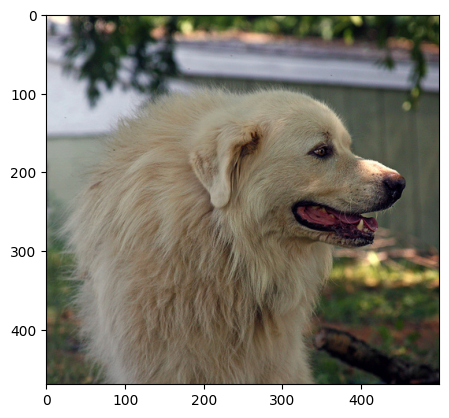

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread("/content/drive/MyDrive/Datasets/Dog_Test.png"))